# Spine Segmentation

In [ ]:
## '런타임' > '런타임 유형 변경' > GPU 

## Package 
import tensorflow as tf
from tensorflow.python.client import device_lib
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

## google drive mount 
from google.colab import drive
drive.mount('/content/gdrive')

print("Tensorflow version: ", tf.__version__)
device_lib.list_local_devices() # CPU or GPU 사용유무 확인

Dataset 출처: http://spineweb.digitalimaginggroup.ca/Index.php?n=Main.Datasets#Dataset_5.3A_Lumbar_vertebra_segmentation_CT_image_database

## 1. Load Dataset

In [ ]:
## Directory 
data_dir = '/content/gdrive/My Drive/Python_Programming/dataset/Spine_CT/'
model_dir = data_dir + 'model/' 
trained_model_dir = model_dir + 'Spine_CT_UNet.h5'
 
 
""" Image """
Image_original = np.load(data_dir + "image_train_val.npy")
## Preprocessing
Image = Image_original.astype('float32')
Image /= 255  # Normalization


""" Mask (Label) """
Mask_original = np.load(data_dir + "mask_train_val.npy")
## Preprocessing
Mask = Mask_original.astype('float32')
Mask /= 255  # Normalization
Mask[Mask > 0.5] = 1
Mask[Mask <= 0.5] = 0

print(np.shape(Image))
print(np.shape(Mask))
    
print("*** Loading Dataset Complete ***") 

### Dataset Check

In [ ]:
!pip install opencv-python
import cv2

##################
num = 25  # 0 ~ 50
##################

imgs = [Image_original[num], Mask_original[num]]

plt.figure(figsize=(15,15))
for i, img in enumerate(imgs):
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    plt.subplot(1, 2, i+1)
    plt.imshow(img)
    
    frame = plt.gca()
    frame.axes.xaxis.set_ticklabels([])
    frame.axes.yaxis.set_ticklabels([])

### Dataset Splitting 

In [ ]:
""" Image """
X_train = Image[:400]
X_val = Image[400:]


""" Mask (Label) """
y_train = Mask[:400]
y_val = Mask[400:]

## 2. Augmentation

### Augmentation Check

In [ ]:
def image_generator(generator, data_x, data_y, seed, batch_size):
    iterator = generator.flow(data_x, data_y,
                              batch_size=batch_size,
                              seed=seed,
                              shuffle=True)
    
    for batch_x, batch_y in iterator:
        yield batch_x, batch_y

##############################################################################
sample = Image_original[10] # 0 ~ 40,  10번째 Sample
count = 10  # Sample 확인    

data_aug_gen = tf.keras.preprocessing.image.ImageDataGenerator(
                       rotation_range= 15,
                       shear_range = 0.2,
                       zoom_range = [0.8, 1.2],
                       width_shift_range= 1.0,
                       height_shift_range= 1.0,
                       horizontal_flip=False,
                       vertical_flip=False
                      # fill_mode='reflect' # constant, nearest, reflect, wrap
                       )
##############################################################################

img = cv2.cvtColor(sample, cv2.COLOR_GRAY2RGB)
img = tf.keras.preprocessing.image.img_to_array(img)
img = img.reshape((1,) + img.shape)


""" Save Augmented Images """
augment_dir = data_dir + 'augment_check/'

i = 1
for batch in data_aug_gen.flow(img, batch_size=1, save_to_dir=augment_dir, save_prefix='aug', save_format='png'):
    i += 1
    if i > count: 
        break

### Applying Augmentation

In [ ]:

train_generator = image_generator(data_aug_gen, X_train, y_train, seed=1, batch_size=2)


## 3. Convolutional Neural Network: U-Net

[]

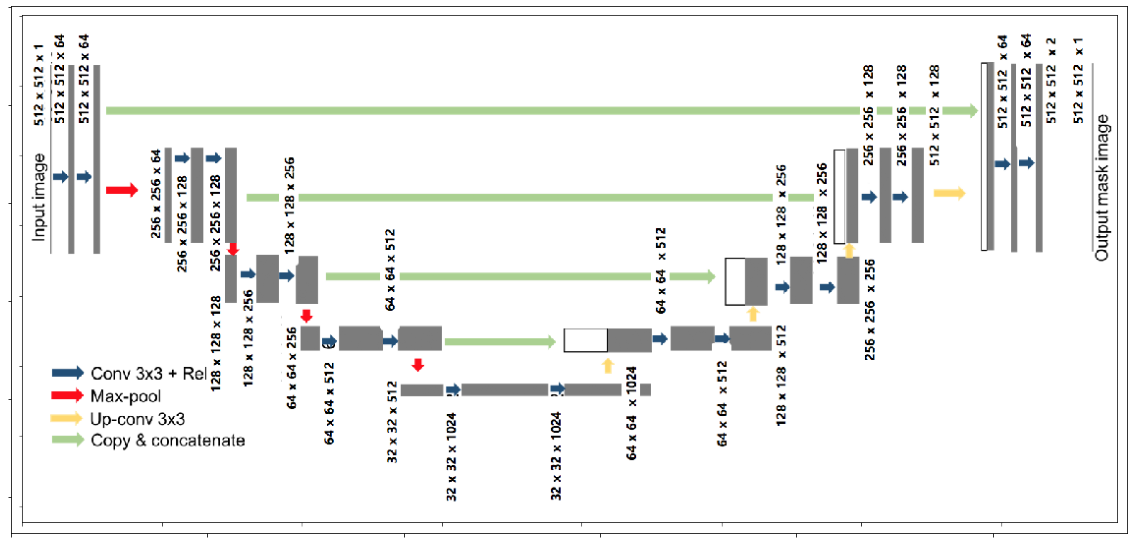

In [ ]:
plot = plt.imread('/content/gdrive/My Drive/Python_Programming/assets/UNet.png')
plt.figure(figsize=(20,10))
plt.imshow(plot)

frame = plt.gca()
frame.axes.xaxis.set_ticklabels([])
frame.axes.yaxis.set_ticklabels([])

![](https://github.com/vdumoulin/conv_arithmetic/blob/master/gif/no_padding_no_strides_transposed.gif?raw=true)

In [ ]:
def UNet(img_input = None):
    
    """ Encoding """
    ### Conv 1
    conv1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding = 'same', kernel_initializer = 'he_normal', name='conv1_1')(img_input)
    conv1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding = 'same', kernel_initializer = 'he_normal', name='conv1_2')(conv1)
    pool1 = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='pool1')(conv1)

    ### Conv 2
    conv2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding = 'same', kernel_initializer = 'he_normal', name='conv2_1')(pool1)
    conv2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding = 'same', kernel_initializer = 'he_normal', name='conv2_2')(conv2)
    pool2 = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='pool2')(conv2)

    ### Conv 3
    conv3 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', name='conv3_1')(pool2)
    conv3 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', name='conv3_2')(conv3)
    pool3 = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(conv3)

    ### Conv 4
    conv4 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', name='conv4_1')(pool3)
    conv4 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', name='conv4_2')(conv4)
    pool4 = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(conv4)

    ### Conv 5
    conv5 = tf.keras.layers.Conv2D(1024, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', name='conv5_1')(pool4)
    conv5 = tf.keras.layers.Conv2D(1024, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', name='conv5_2')(conv5)
   
    """ Decoding """
    ### upconv + conv 6
    upconv6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', name='upconv6_1')(tf.keras.layers.UpSampling2D(size=(2, 2))(conv5))
    merge6 = tf.keras.layers.concatenate([conv4, upconv6], axis=3)

    conv6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', name='upconv6_2')(merge6)
    conv6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', name='upconv6_3')(conv6)
    
    ### Upconv + Conv 7
    upconv7 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', name='upconv7_1')(tf.keras.layers.UpSampling2D(size=(2, 2))(conv6))
    merge7 = tf.keras.layers.concatenate([conv3, upconv7], axis=3)

    conv7 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', name='upconv7_2')(merge7)
    conv7 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu',padding='same', kernel_initializer='he_normal', name='upconv7_3')(conv7)

    ### Upconv + Conv 8
    upconv8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', name='upconv8_1')(tf.keras.layers.UpSampling2D(size=(2, 2))(conv7))
    merge8 = tf.keras.layers.concatenate([conv2, upconv8], axis=3)

    conv8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', name='upconv8_2')(merge8)
    conv8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', name='upconv8_3')(conv8)

    ### Upconv + Conv 9
    upconv9 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', name='upconv9_1')(tf.keras.layers.UpSampling2D(size=(2, 2))(conv8))
    merge9 = tf.keras.layers.concatenate([conv1, upconv9], axis=3)

    conv9 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', name='upconv9_2')(merge9)
    conv9 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', name='upconv9_3')(conv9)
    conv9 = tf.keras.layers.Conv2D(2, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', name='upconv9_4')(conv9)

    ### Conv 10
    conv10 = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid', name = 'conv10')(conv9)

    # Create model
    model = tf.keras.models.Model(img_input, conv10, name='U-Net')

    return model

### Load Model

In [ ]:
input_img = tf.keras.layers.Input(shape=(512, 512, 1))

""" UNet """
model = UNet(img_input = input_img)

model.summary() # Display Model 
print("*** Load Model Complete ***")

### Model Configuration

In [ ]:
IoU = tf.keras.metrics.MeanIoU(num_classes=2, name='IoU')

model.compile(loss='binary_crossentropy', 
                    optimizer='Adam',
                    metrics= ['acc']) #[IoU])    

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(model_dir + 'Spine_CT_UNet_201210.h5', 
                                                      monitor='val_acc', # ' val_acc', 'val_IoU'
                                                      save_best_only=True, 
                                                      verbose=1) 

## 4. Training

In [ ]:
trained_model = model.fit(X_train, y_train,
                          validation_data=(X_val, y_val),
                          batch_size = 2,
                          epochs = 100,
                          callbacks = [model_checkpoint],
                          shuffle = True, 
                          verbose=2)

print("*** Training Model Complete ***")

### Training Process Check 

In [ ]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

acc_ax.plot(trained_model.history['acc'], 'b', label='train acc')
acc_ax.plot(trained_model.history['val_acc'], 'g', label='val acc')
loss_ax.plot(trained_model.history['loss'], 'y', label='train loss')
loss_ax.plot(trained_model.history['val_loss'], 'r', label='val loss')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('acc')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

## 5. Model Prediction

In [ ]:
""" Load Dataset (Test) """
Image_original = np.load(data_dir + "image_test.npy")
## Preprocessing
Image = Image_original.astype('float32')
Image /= 255  # Normalization

X_test = Image
print(np.shape(X_test))

In [ ]:
""" Load Trained Model """
trained_model = tf.keras.models.load_model(model_dir + 'Spine_CT_UNet.h5')
pred = trained_model.predict(X_test, batch_size=1, verbose=0)



""" Check Prediction """   
pred_dir = data_dir + 'prediction_check/' 

for i in range(pred.shape[0]):
    result = tf.keras.preprocessing.image.array_to_img(pred[i])
    result.save(pred_dir + str(i+1).zfill(5) + '.png')
             
        
print("\n***** Model Prediction Complete *****")

(10, 512, 512, 1)

***** Model Prediction Complete *****


## 6. Evaluation

[]

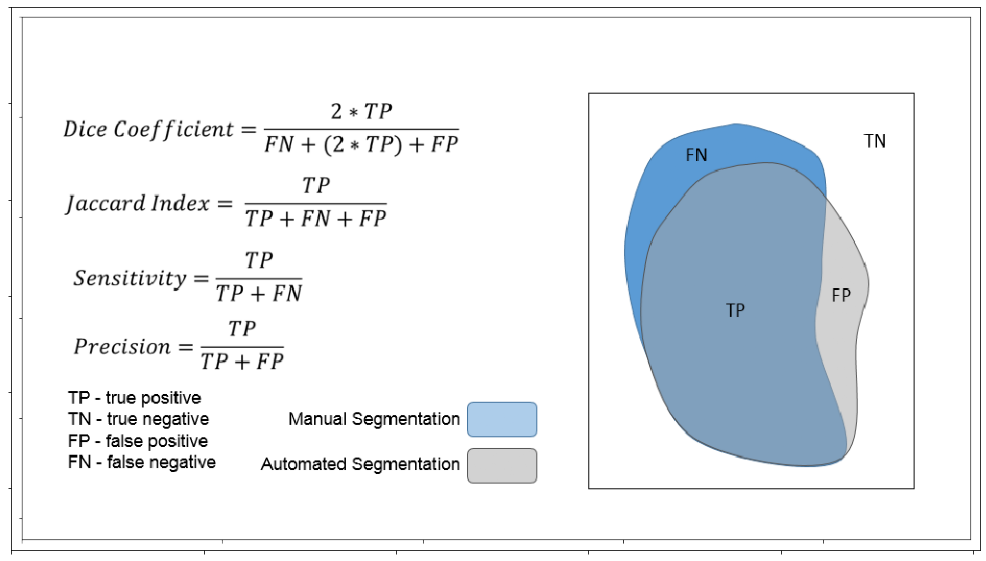

In [ ]:
plot = plt.imread('/content/gdrive/My Drive/Python_Programming/assets/DSC.png')
plt.figure(figsize=(20,10))
plt.imshow(plot)

frame = plt.gca()
frame.axes.xaxis.set_ticklabels([])
frame.axes.yaxis.set_ticklabels([])

In [ ]:
def dice_coefficient(pred_list, mask_list):
    intersect_area = [] 
    for i in range(len(mask_list)): 
        pred_flatten = pred_list[i].flatten()
        mask_flatten = mask_list[i].flatten()
        
        intersect = np.sum(pred_flatten * mask_flatten)
        intersect_area.append(intersect) 

    dsc_list= []
    for i in range(len(mask_list)):
        pred_flatten = pred_list[i].flatten()
        pred_area = np.sum(pred_flatten)

        mask_flatten = mask_list[i].flatten()
        mask_area = np.sum(mask_flatten)

        dsc = intersect_area[i] * 2 / (mask_area + pred_area)
        dsc_list.append(dsc)

    dsc_average = np.average(dsc_list)    
    
    return dsc_average

In [ ]:
# !pip install glob2
import glob

""" Load Prediction Result """    
pred_list = []
for i, pred_img in enumerate(glob.glob(pred_dir + '*.png')):
    pred = cv2.imread(pred_img, 0)
    _, thresh_pred = cv2.threshold(pred, 127,255, cv2.THRESH_BINARY)
    pred_list.append(thresh_pred/255) 

    
""" Load Mask (Label) """
mask_list = []
mask = np.load(data_dir + "mask_test.npy")
for i in range(len(mask)):
    _, thresh_mask = cv2.threshold(mask[i], 127,255, cv2.THRESH_BINARY)
    mask_list.append(thresh_mask/255) 

    
""" Dice Similarity Coefficient """
dsc = dice_coefficient(pred_list, mask_list)
print(dsc)